# Tutorial 9-3: The Time Traveler – "Time Series Forecasting with Seq2Seq"

**Course:** CSEN 342: Deep Learning  
**Topic:** Sequence-to-Sequence (Seq2Seq), Attention Mechanisms, and Time Series Forecasting

## Objective
Sequence-to-Sequence models aren't just for translation. They are powerful tools for any problem where you map one sequence to another.

In this tutorial, we will apply the **Seq2Seq** architecture (Slide 69) to **Time Series Forecasting**. We will predict future weather conditions based on past history.

We will compare two architectures:
1.  **Standard Seq2Seq (The Bottleneck):** Compresses history into a single vector. Often struggles with long horizons.
2.  **Seq2Seq with Attention (The Solution):** Allows the model to look back at specific past time steps (Slide 8).

---

## Part 1: Data Preparation (Jena Climate Dataset)

We will use the **Jena Climate** dataset recorded by the Max Planck Institute. It contains 14 different features (air temperature, atmospheric pressure, humidity, etc.) recorded every 10 minutes.

**Task:** Given the past 24 hours of data (144 steps), predict the temperature for the next 12 hours (72 steps).

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
from torch.utils.data import DataLoader, Dataset

# 1. Robust Download
data_root = '../data'
os.makedirs(data_root, exist_ok=True)
csv_path = os.path.join(data_root, 'jena_climate_2009_2016.csv')

if not os.path.exists(csv_path):
    print("Downloading Jena Climate Dataset...")
    url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
    zip_path = os.path.join(data_root, 'jena_climate_2009_2016.csv.zip')

    if not os.path.exists(zip_path):
        os.system(f"wget -nc -P {data_root} {url}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_root)
    print("Done.")

# 2. Load and Normalize
df = pd.read_csv(csv_path)
# We will use just 3 features for simplicity: Temperature (T (degC)), Pressure (p (mbar)), Humidity (rho (g/m**3))
features = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
data = df[features].values

# Normalize (Standard Scaling)
mean = data.mean(axis=0)
std = data.std(axis=0)
data = (data - mean) / std

print(f"Data shape: {data.shape}")
print("First 5 rows (Normalized):\n", data[:5])

Data shape: (420551, 3)
First 5 rows (Normalized):
 [[ 0.87422976 -2.0740129   2.29360559]
 [ 0.88021172 -2.12031274  2.34488743]
 [ 0.87542615 -2.1321845   2.35589427]
 [ 0.87303337 -2.10844099  2.32962796]
 [ 0.87303337 -2.10369229  2.32487501]]


### 1.1 Creating Sequences
We need to create sliding windows. 
* **Input (X):** Past 144 steps (24 hours).
* **Target (Y):** Future 72 steps (12 hours) of just Temperature (Column 1).

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_width=144, label_width=72):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.input_width = input_width
        self.label_width = label_width
        
    def __len__(self):
        return len(self.data) - self.input_width - self.label_width

    def __getitem__(self, idx):
        # X: (144, 3) -> All features
        x = self.data[idx : idx + self.input_width]
        # Y: (72, 1) -> Just Temperature (index 1)
        y = self.data[idx + self.input_width : idx + self.input_width + self.label_width, 1:2]
        return x, y

# Split Train/Val
n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

train_ds = TimeSeriesDataset(train_data)
val_ds = TimeSeriesDataset(val_data)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

---

## Part 2: Seq2Seq Model (Encoder-Decoder)

We define a flexible class that can use **Standard** decoding or **Attention** decoding.

**The Encoder:** A GRU that processes the input sequence.
**The Decoder:** A GRU that predicts one step at a time. It feeds its output back into itself as the next input (Autoregressive).

In [7]:
import random

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.W = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (Batch, Hidden)
        # encoder_outputs: (Batch, Seq, Hidden)
        seq_len = encoder_outputs.size(1)
        
        # Expand hidden to match sequence length: (Batch, Seq, Hidden)
        hidden_expanded = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Calculate Energy: (Batch, Seq, Hidden)
        energy = torch.tanh(self.W(torch.cat((hidden_expanded, encoder_outputs), dim=2)))
        
        # Attention Scores: (Batch, Seq, 1)
        scores = self.v(energy)
        attn_weights = torch.softmax(scores, dim=1)
        
        # Context Vector: (Batch, 1, Hidden)
        context = torch.bmm(attn_weights.transpose(1, 2), encoder_outputs)
        
        return context, attn_weights

class Seq2SeqForecaster(nn.Module):
    def __init__(self, input_dim, hidden_size, output_len, use_attention=False):
        super(Seq2SeqForecaster, self).__init__()
        self.use_attention = use_attention
        self.output_len = output_len
        
        self.encoder = nn.GRU(input_dim, hidden_size, batch_first=True)
        
        if use_attention:
            self.attention = Attention(hidden_size)
        
        # Decoder input: 1 (temp value) + Context (if attention)
        dec_input_dim = 1 + (hidden_size if use_attention else 0)
        self.decoder = nn.GRU(dec_input_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, target=None, teacher_forcing_ratio=0.5):
        # x: (Batch, Input_Len, 3)
        # target: (Batch, Output_Len, 1) - Ground Truth for training
        
        batch_size = x.size(0)
        encoder_outputs, hidden = self.encoder(x)
        
        # Initialize decoder input with the last known temperature value
        curr_input = x[:, -1, 1].view(-1, 1) # (Batch, 1)
        
        # Prepare tensor to hold predictions
        outputs = torch.zeros(batch_size, self.output_len, 1).to(x.device)
        
        # Initialize decoder hidden state
        decoder_hidden = hidden.squeeze(0)
        
        for t in range(self.output_len):
            # 1. Prepare Input for RNN step
            if self.use_attention:
                context, _ = self.attention(decoder_hidden, encoder_outputs)
                # Combine input (Batch, 1) and Context (Batch, 1, Hidden)
                rnn_input = torch.cat((curr_input.unsqueeze(1), context), dim=2)
            else:
                rnn_input = curr_input.unsqueeze(1)
                
            # 2. RNN Step
            out, hidden_state_raw = self.decoder(rnn_input, decoder_hidden.unsqueeze(0))
            decoder_hidden = hidden_state_raw.squeeze(0)
            
            # 3. Predict next value
            prediction = self.fc(out) # (Batch, 1, 1)
            outputs[:, t, :] = prediction.squeeze(1)
            
            # 4. Decide Next Input (Teacher Forcing Logic)
            # If we are training (target is not None) AND we hit the coin flip...
            if target is not None and random.random() < teacher_forcing_ratio:
                # Use the GROUND TRUTH from the target as the next input
                curr_input = target[:, t, :] # (Batch, 1)
            else:
                # Use the MODEL'S PREDICTION as the next input
                curr_input = prediction.squeeze(1).detach() 
            
        return outputs

---

## Part 3: Training Loop

We train both models side-by-side to compare Mean Squared Error (MSE).

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(name, use_attn, epochs=10): # Increased to 10 epochs
    print(f"Training {name}...")
    model = Seq2SeqForecaster(input_dim=3, hidden_size=64, output_len=72, use_attention=use_attn).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        # Training on 100 batches per epoch
        for i, (x, y) in enumerate(train_loader):            
            x = x.to(device)
            y = y.to(device) # y shape: (Batch, 72, 1)
            
            optimizer.zero_grad()
            
            # FIX: Pass 'y' (target) and enable teacher forcing (e.g. 0.5)
            preds = model(x, target=y, teacher_forcing_ratio=0.5)
            
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / 100
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")
        
    return model, losses

# Re-train models
model_no_attn, loss_no = train_model("Standard Seq2Seq", use_attn=False)
model_attn, loss_yes = train_model("Seq2Seq + Attention", use_attn=True)

Training Standard Seq2Seq...
Epoch 1: Loss 0.3570
Epoch 2: Loss 0.0929
Epoch 3: Loss 0.0880
Epoch 5: Loss 0.0861
Epoch 6: Loss 0.0853
Epoch 7: Loss 0.0837
Epoch 8: Loss 0.0839
Epoch 9: Loss 0.0831
Epoch 10: Loss 0.0816
Training Seq2Seq + Attention...
Epoch 1: Loss 0.3048
Epoch 2: Loss 0.0950
Epoch 3: Loss 0.0907
Epoch 4: Loss 0.0898
Epoch 5: Loss 0.0874
Epoch 6: Loss 0.0855
Epoch 7: Loss 0.0847
Epoch 8: Loss 0.0837
Epoch 9: Loss 0.0829
Epoch 10: Loss 0.0811


## Part 4: Visualization (Forecasts)

Let's visualize the predictions. In time series, Attention helps the model recognize *periodic* patterns (e.g., "Temperature drops every 24 hours") by attending to the relevant history.

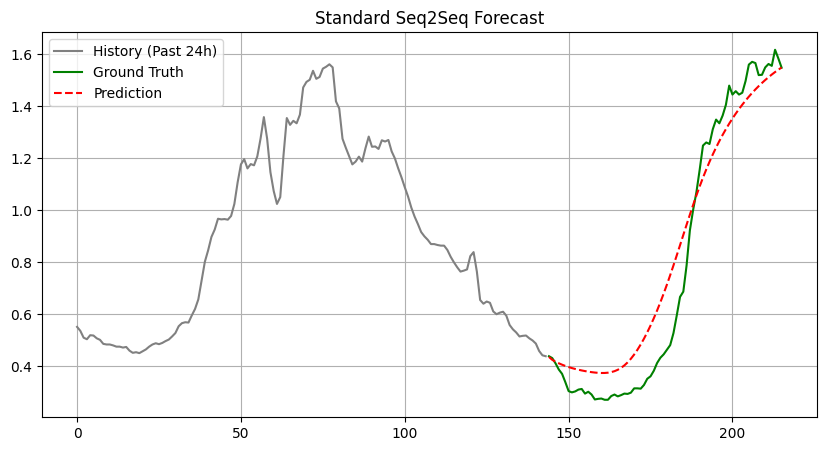

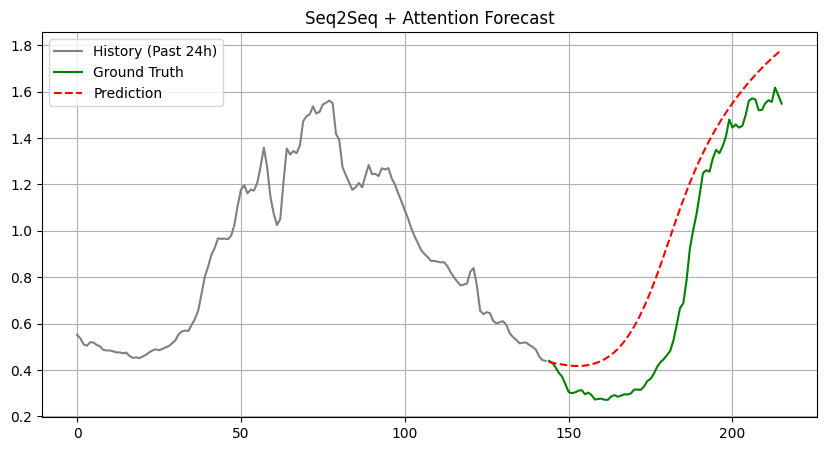

In [11]:
def plot_forecast(model, title):
    model.eval()
    # Get one sample
    x, y = val_ds[0]
    x = x.unsqueeze(0).to(device)
    
    with torch.no_grad():
        preds = model(x)
        
    # Extract arrays
    history = x[0, :, 1].cpu().numpy()
    truth = y[:, 0].numpy()
    forecast = preds[0, :, 0].cpu().numpy()
    
    # Time axis
    t_history = np.arange(0, 144)
    t_future = np.arange(144, 144+72)
    
    plt.figure(figsize=(10, 5))
    plt.plot(t_history, history, label='History (Past 24h)', color='gray')
    plt.plot(t_future, truth, label='Ground Truth', color='green')
    plt.plot(t_future, forecast, label='Prediction', color='red', linestyle='--')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_forecast(model_no_attn, "Standard Seq2Seq Forecast")
plot_forecast(model_attn, "Seq2Seq + Attention Forecast")

### Conclusion
Notice how the **Attention** model tends to track the *trend* and *periodicity* better. 

The Standard Seq2Seq forces the encoder to compress 24 hours of complex weather fluctuations into one tiny vector. By the time the decoder generates the 12th hour of the future, it has likely "forgotten" exactly what the temperature curve looked like yesterday.

Attention allows the decoder to "peek" at yesterday's temperature curve directly while generating today's forecast.